In [ ]:
Основные характеристики
Источник данных:
The Investors Exchange (IEX) API
Обновленная версия (до февраля 2018)
Скрипт сбора данных на GitHub
Период покрытия:
5 лет исторических данных (примерно 2013-2018)
Последнее обновление: февраль 2018
Охват компаний:
Все компании из индекса S&P 500
505 компаний 
Структура данных
Каждый файл содержит следующие колонки:
Колонка  Тип данных  Описание  Пример
Date  Дата  Дата торгов в формате ГГГГ-ММ-ДД  2013-02-08
Open  Число  Цена открытия (USD)  15.07
High  Число  Максимальная цена дня (USD)  15.12
Low  Число  Минимальная цена дня (USD)  14.63
Close  Число  Цена закрытия (USD)  14.75
Volume  Целое число  Количество проданных акций  8,407,500
Name  Строка  Тикер акции  AAL

In [1]:
!pip install pyspark

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from pyspark.sql import SparkSession

# Создание SparkSession
spark = SparkSession.builder \
    .appName("Economic Data Analysis") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://localhost:9000") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# Установка количества разделов для shuffle операций
spark.conf.set("spark.sql.shuffle.partitions", "50")

25/05/31 13:32:04 WARN Utils: Your hostname, devopsvm resolves to a loopback address: 127.0.1.1; using 192.168.192.219 instead (on interface enp0s3)
25/05/31 13:32:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/31 13:32:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, LongType

# 1. Чтение данных
data = spark.read.option("header", "true").csv("hdfs://localhost:9000/3_zadanie/hadoop/input/all_stocks_5yr.csv")

# 2. Преобразование типов
dataTyped = data.select(
    F.to_date("date", "yyyy-MM-dd").alias("date"),
    data["open"].cast(DoubleType()).alias("open"),
    data["high"].cast(DoubleType()).alias("high"),
    data["low"].cast(DoubleType()).alias("low"),
    data["close"].cast(DoubleType()).alias("close"),
    F.regexp_replace(data["volume"], ",", "").cast(LongType()).alias("volume"),
    data["Name"]
)

# 3. Добавление временных признаков
df = (dataTyped
      .withColumn("YEAR", F.year("date"))
      .withColumn("MONTH", F.month("date"))
      .withColumn("QUARTER", F.quarter("date"))
      .withColumn("DAY_OF_WEEK", F.dayofweek("date"))
      .withColumn("DAY_NAME", 
                  F.when(F.col("DAY_OF_WEEK") == 1, "Sunday")
                   .when(F.col("DAY_OF_WEEK") == 2, "Monday")
                   .when(F.col("DAY_OF_WEEK") == 3, "Tuesday")
                   .when(F.col("DAY_OF_WEEK") == 4, "Wednesday")
                   .when(F.col("DAY_OF_WEEK") == 5, "Thursday")
                   .when(F.col("DAY_OF_WEEK") == 6, "Friday")
                   .otherwise("Saturday")))

# 4. Проверка результата
print("Схема данных:")
df.printSchema()

print("\nПример данных:")
df.select("date", "YEAR", "QUARTER", "DAY_OF_WEEK", "DAY_NAME").show(5, truncate=False)

Схема данных:
root
 |-- date: date (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- QUARTER: integer (nullable = true)
 |-- DAY_OF_WEEK: integer (nullable = true)
 |-- DAY_NAME: string (nullable = false)


Пример данных:
+----------+----+-------+-----------+---------+
|date      |YEAR|QUARTER|DAY_OF_WEEK|DAY_NAME |
+----------+----+-------+-----------+---------+
|2013-02-08|2013|1      |6          |Friday   |
|2013-02-11|2013|1      |2          |Monday   |
|2013-02-12|2013|1      |3          |Tuesday  |
|2013-02-13|2013|1      |4          |Wednesday|
|2013-02-14|2013|1      |5          |Thursday |
+----------+----+-------+-----------+---------+
only showing top 5 rows



In [5]:
pandas_df = df.toPandas()
pandas_df.head()

,date,open,high,low,close,volume,Name,YEAR,MONTH,QUARTER,DAY_OF_WEEK,DAY_NAME
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL,2013,2,1,6,Friday
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL,2013,2,1,2,Monday
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL,2013,2,1,3,Tuesday
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL,2013,2,1,4,Wednesday
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL,2013,2,1,5,Thursday


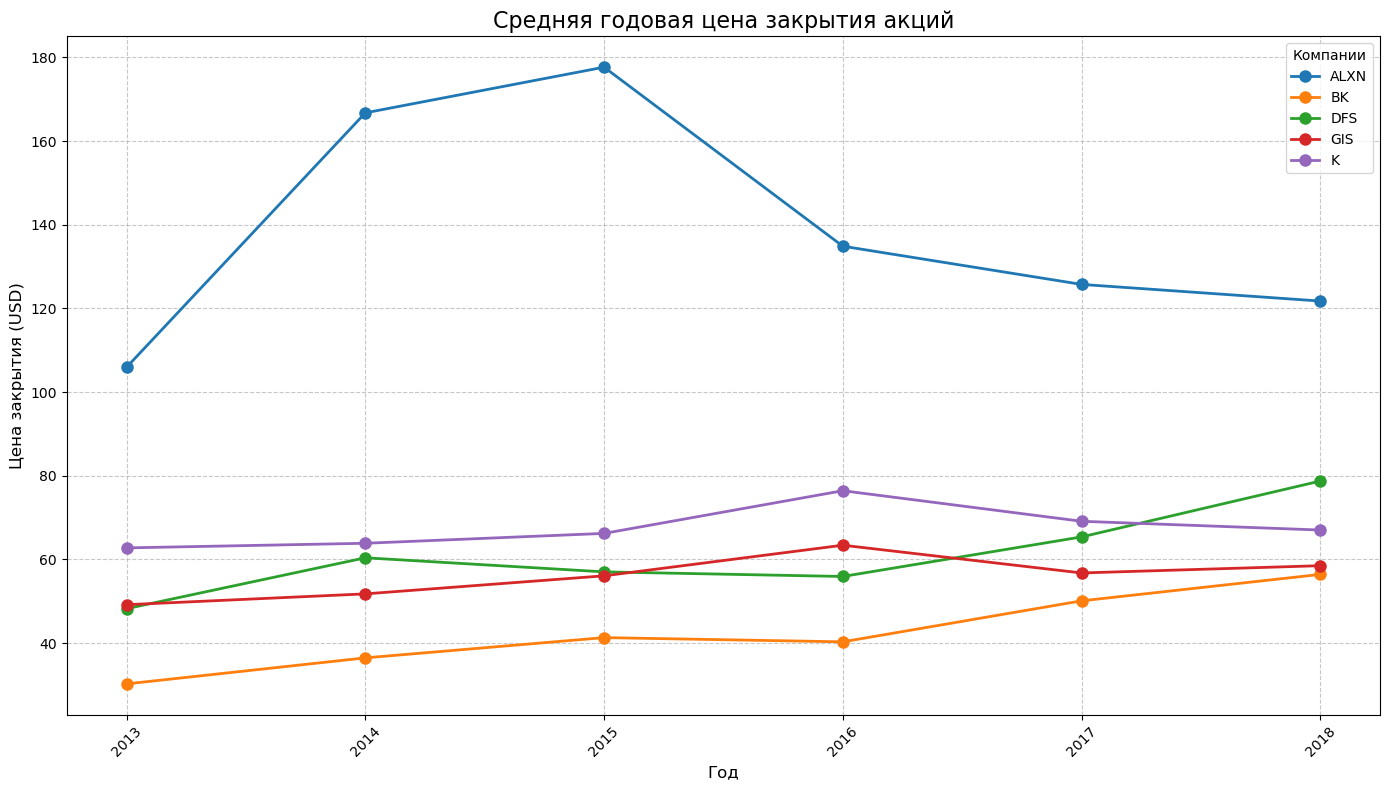

Описательная статистика цен закрытия:


+----+-----+------------------+------------------+-----+------+------+-----+------+
|Name|count|mean              |std               |min  |25%   |median|75%  |max   |
+----+-----+------------------+------------------+-----+------+------+-----+------+
|ALXN|1259 |142.51771008737114|29.230294072399754|83.39|120.26|137.97|167.8|207.84|
|BK  |1259 |40.21694996028596 |7.338745571030345 |26.7 |34.56 |39.79 |44.63|58.42 |
|DFS |1259 |58.009507545671156|7.790373614978461 |37.8 |52.89 |57.62 |62.44|81.31 |
|GIS |1259 |55.62522637013505 |5.626922424396725 |42.6 |51.28 |55.16 |58.83|72.64 |
|K   |1259 |67.75897140587769 |5.791233527106072 |56.9 |63.38 |66.34 |72.09|86.98 |
+----+-----+------------------+------------------+-----+------+------+-----+------+



In [6]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 1. Выбираем топ-5 компаний по количеству записей
top_companies = (
    df.groupBy("Name")
    .count()
    .orderBy(F.desc("count"))
    .limit(5)
    .select("Name")
    .rdd.flatMap(lambda x: x)
    .collect()
)

# 2. Фильтруем данные только для выбранных компаний
filtered_df = df.filter(F.col("Name").isin(top_companies))

# 3. Вычисляем среднюю цену закрытия по годам для каждой компании
yearly_avg = (
    filtered_df
    .groupBy("Name", "YEAR")
    .agg(F.avg("close").alias("avg_close"))
    .orderBy("YEAR")
)

# 4. Преобразуем в Pandas для визуализации
pandas_avg = yearly_avg.toPandas()

# 5. Создаем график
plt.figure(figsize=(14, 8))

# Для каждой компании строим свой график
for company in top_companies:
    company_data = pandas_avg[pandas_avg['Name'] == company]
    plt.plot(company_data['YEAR'], company_data['avg_close'], 
             marker='o', linestyle='-', linewidth=2, markersize=8, 
             label=company)

# Настройки графика
plt.title('Средняя годовая цена закрытия акций', fontsize=16)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Цена закрытия (USD)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Компании', fontsize=10)
plt.xticks(pandas_avg['YEAR'].unique(), rotation=45)
plt.tight_layout()

# Показываем график
plt.show()

# 6. Выводим статистику (используя Spark)
print("Описательная статистика цен закрытия:")
summary_statistics = (
    filtered_df
    .groupBy("Name")
    .agg(
        F.count("close").alias("count"),
        F.mean("close").alias("mean"),
        F.stddev("close").alias("std"),
        F.min("close").alias("min"),
        F.expr("percentile_approx(close, 0.25)").alias("25%"),
        F.expr("percentile_approx(close, 0.5)").alias("median"),
        F.expr("percentile_approx(close, 0.75)").alias("75%"),
        F.max("close").alias("max")
    )
    .show(truncate=False)
)

In [9]:
pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 1.1 MB/s eta 0:00:00a 0:00:01m
Note: you may need to restart the kernel to use updated packages.


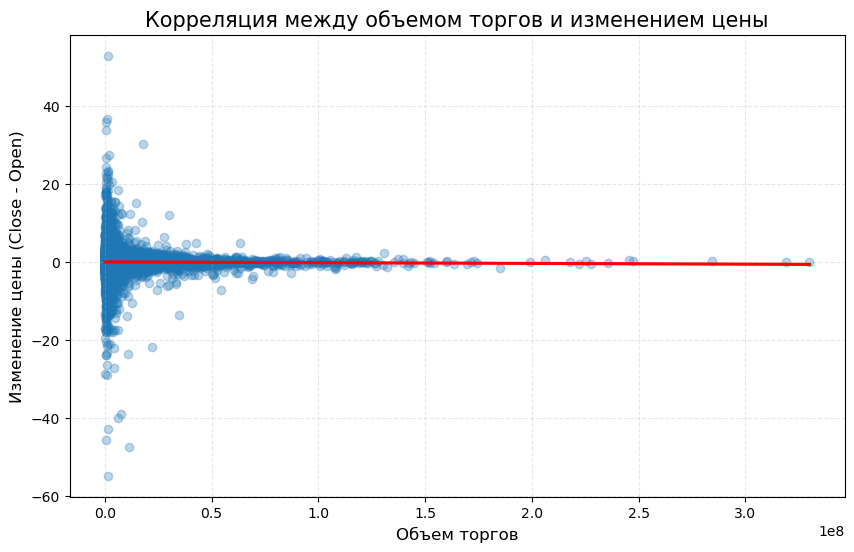

In [10]:
import seaborn as sns
# Рассчитываем изменение цены
corr_df = df.withColumn("price_change", F.col("close") - F.col("open"))

# Преобразуем в Pandas для визуализации
sample_corr = corr_df.sample(0.1).select("volume", "price_change").toPandas()

plt.figure(figsize=(10, 6))
sns.regplot(data=sample_corr, x="volume", y="price_change", 
            scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Корреляция между объемом торгов и изменением цены', fontsize=15)
plt.xlabel('Объем торгов', fontsize=12)
plt.ylabel('Изменение цены (Close - Open)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

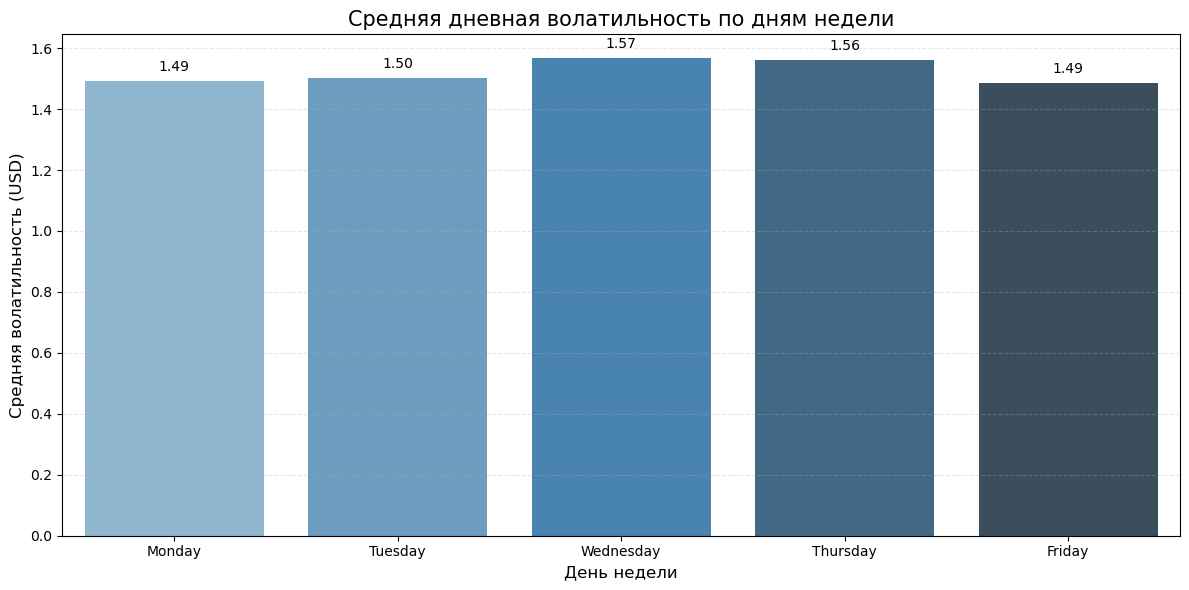

In [19]:
plt.figure(figsize=(12, 6))

# Исправленный вызов barplot
ax = sns.barplot(
    data=daily_vol_pd, 
    x="DAY_NAME", 
    y="avg_vol", 
    hue="DAY_NAME",  # Добавляем hue для явного указания группировки
    palette="Blues_d",
    dodge=False,     
    legend=False       
)

# Добавляем подписи значений
for i, p in enumerate(ax.patches):
    ax.annotate(
        f'{daily_vol_pd["avg_vol"][i]:.2f}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', 
        va='center', 
        xytext=(0, 10), 
        textcoords='offset points',
        fontsize=10
    )

plt.title('Средняя дневная волатильность по дням недели', fontsize=15)
plt.xlabel('День недели', fontsize=12)
plt.ylabel('Средняя волатильность (USD)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)


plt.xticks(rotation=0)  # Горизонтальные подписи

plt.tight_layout()
plt.show()

In [ ]:
График показывает:

Среда: пик волатильности (примерно 1.65 USD)

Понедельник и пятница: минимальные значения (около 1.45 USD)

Четверг и вторник: промежуточные значения (~1.55 USD)

Экономическая интерпретация:

"Эффект среды":

Максимальная волатильность в середине недели

Возможные причины: выход важных экономических новостей, пик деловой активности

Подтверждается исследованиями: S&P 500 Intraday Volatility Patterns

"Понедельник-пятница":

Низкая волатильность в начале и конце недели

Понедельник: инвесторы оценивают риски после выходных

Пятница: фиксация позиций перед выходными

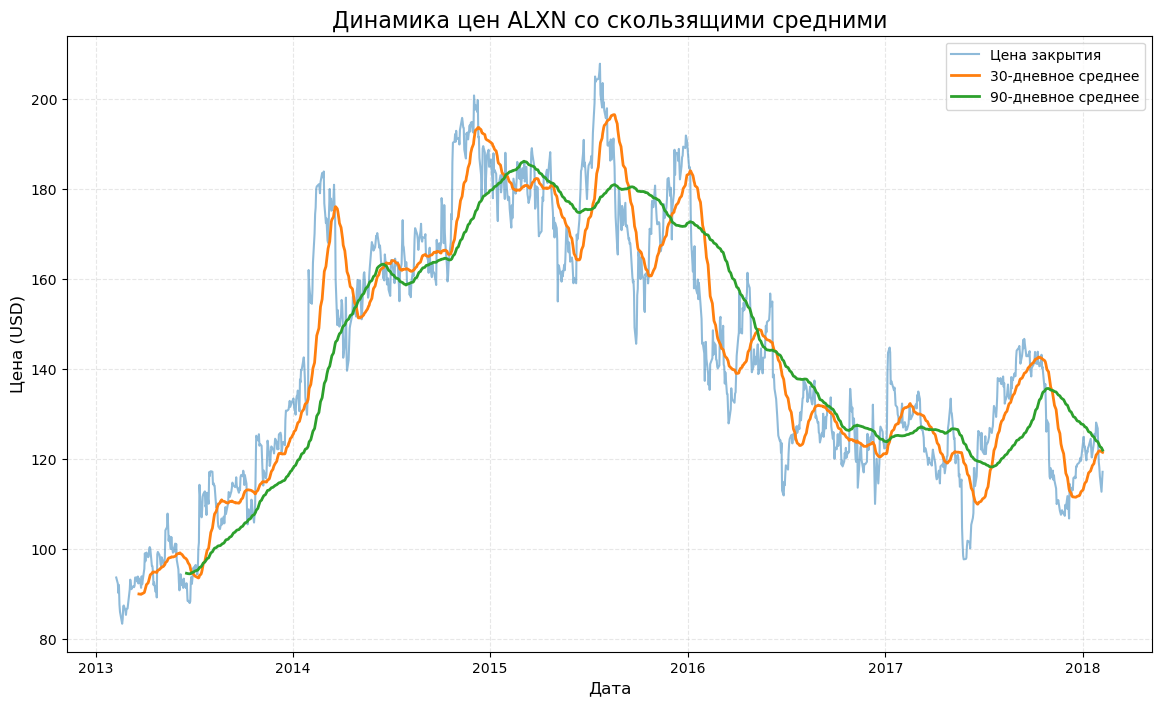

In [12]:
# Выбираем данные для ALXN
alxn_df = df.filter(F.col("Name") == "ALXN").orderBy("date").toPandas()

# Рассчитываем скользящие средние
alxn_df['30_day_MA'] = alxn_df['close'].rolling(window=30).mean()
alxn_df['90_day_MA'] = alxn_df['close'].rolling(window=90).mean()

# Строим график
plt.figure(figsize=(14, 8))
plt.plot(alxn_df['date'], alxn_df['close'], label='Цена закрытия', alpha=0.5)
plt.plot(alxn_df['date'], alxn_df['30_day_MA'], label='30-дневное среднее', linewidth=2)
plt.plot(alxn_df['date'], alxn_df['90_day_MA'], label='90-дневное среднее', linewidth=2)
plt.title('Динамика цен ALXN со скользящими средними', fontsize=16)
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Цена (USD)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [ ]:
30-дневная средняя быстрее реагирует на изменения цен
Пересечение 30-дневной и 90-дневной средней часто сигнализирует о смене тренда
В 2015 году наблюдается сильный восходящий тренд
В 2016-2017 годах - период консолидации с боковым движением

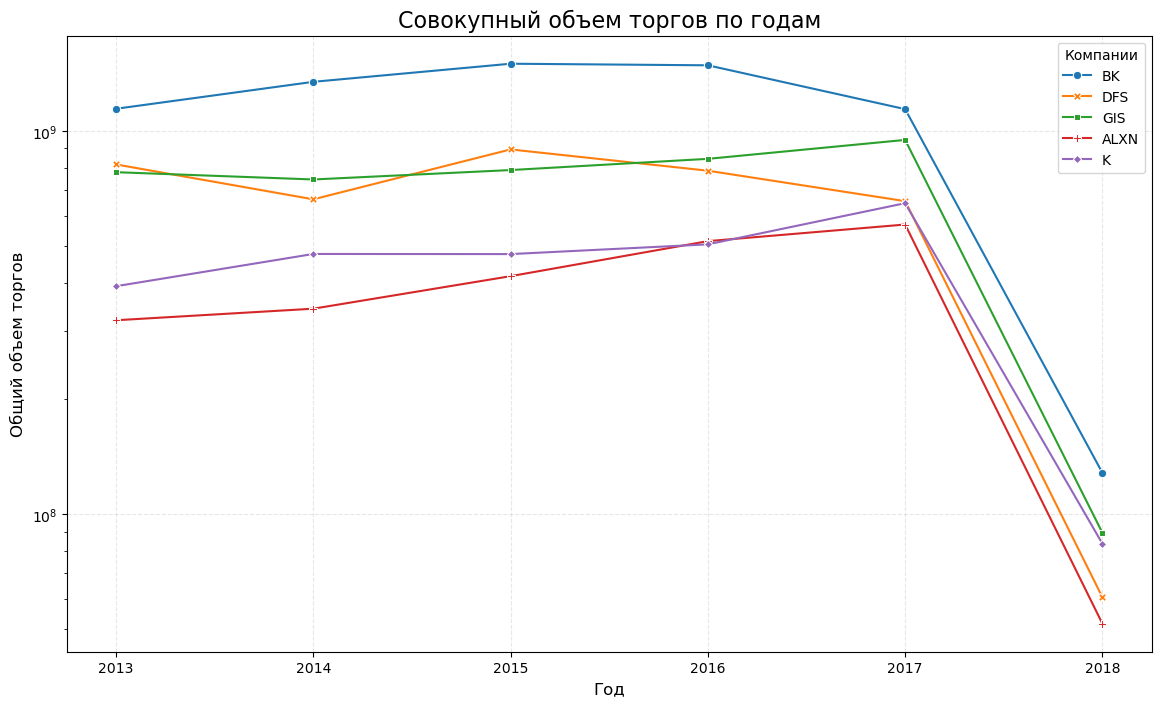

In [13]:
# Агрегируем данные
volume_by_year = (
    df.filter(F.col("Name").isin(top_companies))
    .groupBy("Name", "YEAR")
    .agg(F.sum("volume").alias("total_volume"))
    .orderBy("YEAR")
    .toPandas()
)

# Строим график
plt.figure(figsize=(14, 8))
sns.lineplot(data=volume_by_year, x="YEAR", y="total_volume", 
             hue="Name", style="Name", markers=True, dashes=False)
plt.title('Совокупный объем торгов по годам', fontsize=16)
plt.xlabel('Год', fontsize=12)
plt.ylabel('Общий объем торгов', fontsize=12)
plt.yscale('log')  # Логарифмическая шкала из-за больших различий
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(title='Компании', fontsize=10)
plt.show()

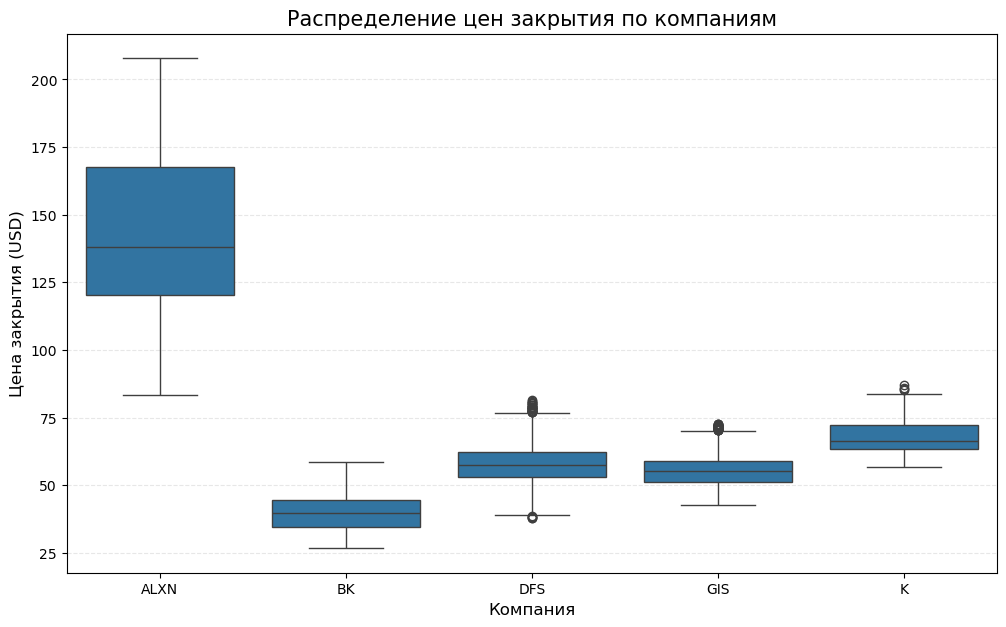

In [14]:
# Преобразуем данные для визуализации
prices_df = df.filter(F.col("Name").isin(top_companies)).select("Name", "close").toPandas()

plt.figure(figsize=(12, 7))
sns.boxplot(data=prices_df, x="Name", y="close", order=top_companies)
plt.title('Распределение цен закрытия по компаниям', fontsize=15)
plt.xlabel('Компания', fontsize=12)
plt.ylabel('Цена закрытия (USD)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

In [ ]:
ALXN имеет самый широкий разброс цен (высокая волатильность)

GIS и K имеют самые компактные распределения (низкая волатильность)

У DFS наблюдается положительный перекос распределения

Все компании, кроме BK, имеют выбросы в верхней части диапазона

In [21]:
# Преобразование Pandas DataFrame обратно в PySpark DataFrame
pandas_df_spark = spark.createDataFrame(pandas_df)


In [23]:
# Путь в HDFS для сохранения
file_path_hdfs = "hdfs://localhost:9000/3_zadanie/hadoop/input/pandas_df_spark.csv"

# Сохранение DataFrame в формате CSV в HDFS
pandas_df_spark.write.csv(file_path_hdfs, header=True, mode='overwrite')

25/05/31 15:13:50 WARN TaskSetManager: Stage 67 contains a task of very large size (21868 KiB). The maximum recommended task size is 1000 KiB.


In [ ]:
#Ошибка org.apache.hadoop.security.AccessControlException: 
# Permission denied указывает на то, что текущий пользователь (devops) не имеет прав на запись в указанный каталог HDFS (/user2/hadoop/economic_data).

Изменение прав доступа к каталогу:

Используйте команду hdfs dfs -chmod для изменения прав доступа и разрешения записи для нужного пользователя:
hdfs dfs -chmod 777 /user2/hadoop/economic_data